In [1]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import platform

import math    # модуль доступа к математическим функциям
from math import *    # подключаем все содержимое модуля math, используем без псевдонимов

import numpy as np
from numpy import nan

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import scipy as sci
import scipy.stats as sps

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

import statistics as stat    # module 'statistics' has no attribute '__version__'

import sympy as sym

## External methods

In [2]:
INCH = 25.4                                                                     # мм/дюйм
NUMBER_CHAR_LINE = 79    # число символов в строке
TABLE_HEAD_1 = ('#' * NUMBER_CHAR_LINE)
TABLE_HEAD_2 = ('=' * NUMBER_CHAR_LINE)
TABLE_HEAD_3 = ('-' * NUMBER_CHAR_LINE)

def descriptive_characteristics(
    X,
    p_level:            float = 0.95,
    auxiliary_table:    bool = False):
    
    """
    Принимает в качестве аргумента np.ndarray и возвращает DataFrame,
    содержащий основные статистические характеристики с доверительными 
    интервалами и ошибками определения - расширенный аналог describe.

    Args:
        X:                       
            мсходный массив данных
            
        p_level (float, optional):           
            доверительная вероятность. 
            Defaults to 0.95.
            
        auxiliary_table (bool, optional):    
            логический параметр: True/False - возвращать/не возвращать таблицу 
            со вспомогательными значениями.
            Defaults to False.
    
    Returns:
        result (pd.core.frame.DataFrame):
            результат            
        
        result_auxiliary (pd.core.frame.DataFrame):
            таблица со вспомогательными значениями
                    
    """
    
    a_level = 1 - p_level
    
    # Вспомогательные величины
    #-------------------------
    
    # распределение Стьюдента
    f_t = len(X)-1    # число степеней свободы для t-квантиля
    gamma_t = 1 - a_level/2    # довер.вер-ть для t-квантиля
    t_p = sps.t.ppf(gamma_t, f_t)    # табл.значение t-квантиля
    
    # нормальное распределение
    u_p = sps.norm.ppf(p_level, 0, 1)    # табл.значение квантиля норм.распр.
    
    # распределение хи-квадрат
    f_chi2 = len(X) - 1    # число степеней свободы хи2
    gamma_chi2_low = (1 + p_level)/2    # довер.вер-ть хи2 нижн.
    gamma_chi2_up = (1 - p_level)/2    # довер.вер-ть хи2 верх.
    chi2_p_low = sps.chi2.ppf(gamma_chi2_low, f_chi2)
    chi2_p_up = sps.chi2.ppf(gamma_chi2_up, f_chi2)
    
    # Расчет статистических характеристик
    #------------------------------------
    
    # объем выборки
    N = round(len(X), 0)
    
    # среднее арифметическое
    X_mean = X.mean()
    X_std = X.std(ddof = 1)
    conf_int_low_X_mean = X_mean - sps.t.ppf(gamma_t, f_t) * X_std/math.sqrt(N)
    conf_int_up_X_mean = X_mean + sps.t.ppf(gamma_t, f_t) * X_std/math.sqrt(N)
    abs_err_X_mean = X_std / math.sqrt(N)
    rel_err_X_mean = abs_err_X_mean / X_mean * 100
    
    # медиана
    Me = np.median(X)
    C_p_Me = floor((N +  1 - u_p*sqrt(N + 0.5 - 0.25*u_p**2))/2) # вспом.величина
    X_sort = np.array(sorted(X))
    conf_int_low_Me = X_sort[C_p_Me-1]
    conf_int_up_Me = X_sort[(N - C_p_Me + 1) - 1]
    abs_err_Me = abs_err_X_mean * sqrt(pi/2)
    rel_err_Me = abs_err_Me / Me * 100
    # довер.интервал для медианы - см. ГОСТ Р 50779.24-2005, п.6.2-6.3
    if X_mean < Me:
        Me_note = 'distribution is negative skewed \
            (левосторонняя асимметрия) (mean < median)'
    else:
        Me_note = 'distribution is positive skewed \
            (правосторонняя асимметрия) (mean > median)'
    
    # мода        
    Mo = stat.mode(X)
    
    # выборочная дисперсия
    D_X = np.var(X, ddof = 1)
    conf_int_low_D_X = D_X * (N - 1)/chi2_p_low
    conf_int_up_D_X = D_X * (N - 1)/chi2_p_up
    abs_err_D_X = D_X / sqrt(2*N)
    rel_err_D_X = abs_err_D_X / D_X * 100
    
    # выборочное С.К.О.
    conf_int_low_X_std = sqrt(conf_int_low_D_X)
    conf_int_up_X_std = sqrt(conf_int_up_D_X)
    abs_err_X_std = X_std / sqrt(2*N)
    rel_err_X_std = abs_err_X_std / X_std * 100   
    
    # выборочное С.Л.О.
    # https://en.wikipedia.org/wiki/Median_absolute_deviation
    # также смотри 
    # https://www.statsmodels.org/stable/generated/statsmodels.robust.scale.mad.html
    #mad_X = pd.Series(X).mad()
    mad_X = sps.median_abs_deviation(X)
        
    # минимальное, максимальное значения и вариационный размах
    min_X = np.amin(X)
    max_X = np.amax(X)
    R = np.ptp(X)
    
    # выборочные квантили
    np.percentile(X, 25)
    np.percentile(X, 50)
    np.percentile(X, 75)
    IQR = np.percentile(X, 75) - np.percentile(X, 25)
    np.percentile(X, 5)
    np.percentile(X, 95)
    
    # коэффициент вариации
    CV = sps.variation(X)
    conf_int_low_CV = CV / (1 + u_p/sqrt(2*(N - 1)) * sqrt(1 + 2*CV**2))
    conf_int_up_CV = CV / (1 - u_p/sqrt(2*(N - 1)) * sqrt(1 + 2*CV**2))
    abs_err_CV = CV / sqrt(N - 1) * sqrt(0.5 + CV**2)
    rel_err_CV = abs_err_CV / CV * 100
    if CV <= 0.33:
        CV_note = 'CV <= 0.33 (homogeneous population)'
    else:
        CV_note = 'CV > 0.33 (heterogeneous population)'
    
    # квартильный коэффициент дисперсии
    QCD = (np.percentile(X, 75) - np.percentile(X, 25)) / (np.percentile(X, 75) 
        + np.percentile(X, 25))
    
    # показатель асимметрии
    As = sps.skew(X)
    abs_err_As = sqrt(6*N*(N-1) / ((N-2)*(N+1)*(N+3)))
    rel_err_As = abs_err_As / As * 100
    
    if abs(As) <= 0.25:
        As_note = 'distribution is approximately symmetric \
            (распределение приблизительно симметричное) (abs(As)<=0.25)'
    elif abs(As) <= 0.5:
        if As < 0:
            As_note = 'distribution is moderately negative skewed \
                (умеренная левосторонняя асимметрия) (abs(As)<=0.5, As<0)'
        else:
            As_note = 'distribution is moderately positive skewed \
                (умеренная правосторонняя асимметрия) (abs(As)<=0.5, As>0)'
    else:
        if As < 0:
            As_note = 'distribution is highly negative skewed \
                (значительная левосторонняя асимметрия) (abs(As)>0.5, As<0)'
        else:
            As_note = 'distribution is highly positive skewed \
                (значительная правосторонняя асимметрия) (abs(As)>0.5, As>0)'
            
    # показатель эксцесса
    Es = sps.kurtosis(X)
    abs_err_Es = sqrt(24*N*(N-1)**2 / ((N-3)*(N-2)*(N+3)*(N+5)))
    rel_err_Es = abs_err_Es / Es * 100
    if Es > 0:
        Es_note = 'leptokurtic distribution (островершинное распределение) \
            (Es>0)'
    elif Es < 0:
        Es_note = 'platykurtic distribution (плосковершинное распределение) \
            (Es<0)'
    else:
        Es_note = 'mesokurtic distribution (нормальное распределение) (Es=0)'
    
    # Создадим DataFrame для сводки результатов
    #------------------------------------------
    
    # основная таблица
    result = pd.DataFrame({
        'characteristic': (
            'count', 'mean', 'median', 'mode',
            'variance', 'standard deviation', 'mean absolute deviation',
            'min', '5%', '25% (Q1)', '50% (median)', '75% (Q3)', '95%', 'max',
            'range = max − min', 'IQR = Q3 - Q1', 'CV = std/mean', 
            'QCD = (Q3-Q1)/(Q3+Q1)',
            'skew (As)', 'kurtosis (Es)'),
        'evaluation': (
            N, X_mean, Me, Mo,
            D_X, X_std, mad_X,
            min_X,
            np.percentile(X, 5), np.percentile(X, 25), np.percentile(X, 50), 
            np.percentile(X, 75), np.percentile(X, 95),
            max_X,
            R, IQR, CV, QCD,
            As, Es),
        'conf.int.low': (
            '', conf_int_low_X_mean, conf_int_low_Me, '',

            conf_int_low_D_X,  conf_int_low_X_std, '',
            '', '', '', '', '', '', '',
            '', '', conf_int_low_CV, '',
            '', ''),
        'conf.int.high': (
            '', conf_int_up_X_mean, conf_int_up_Me, '',
            conf_int_up_D_X, conf_int_up_X_std,
            '', '', '', '', '', '', '', '',
            '', '', conf_int_up_CV, '',
            '', ''),
        'abs.err.': (
            '', abs_err_X_mean, abs_err_Me, '',
            abs_err_D_X, abs_err_X_std,
            '', '', '', '', '', '', '', '',
            '', '', abs_err_CV, '',
            abs_err_As, abs_err_Es),
        'rel.err.(%)': (
            '', rel_err_X_mean, rel_err_Me, '',
            rel_err_D_X, rel_err_X_std,
            '', '', '', '', '', '', '', '',
            '', '', rel_err_CV, '',
            rel_err_As, rel_err_Es),
        'note': (
            '', '', Me_note, '', '', '', '', '', '', '', '', '', '', '', '', 
            '', CV_note, '',
            As_note, Es_note)
        })
            
    # вспомогательная таблица
    result_auxiliary = pd.DataFrame({
        'characteristic': (
            'confidence probability',
            'significance level',
            'count',
            "quantile of the Student's distribution",
            'quantile of the normal distribution',
            'quantile of the chi-square distribution (low)',
            'quantile of the chi-square distribution (up)'),
        'designation, formula': (
            'p',
            'a = 1 - p',
            'n',
            't(1 - a/2, n-1)',
            'u(p)',
            'chi2((1+p)/2, n-1)',
            'chi2((1-p)/2, n-1)'),
        'evaluation': (
            p_level, a_level, N, t_p, u_p, chi2_p_low, chi2_p_up)}
        )
    
    # вывод результатов
    if auxiliary_table:
        return result, result_auxiliary
    else:
        return result
    
def graph_hist_boxplot_mpl(
    X,
    Xmin=None, Xmax=None,
    bins_hist='auto',
    density_hist=False,
    title_figure=None, title_figure_fontsize=18,
    title_axes=None, title_axes_fontsize=16,
    x_label=None,
    label_fontsize=14, tick_fontsize=12, label_legend_fontsize=10,
    graph_size=(297/INCH, 210/INCH),
    file_name=None):
    
    X = np.array(X)
        
    if not(Xmin) and not(Xmax):
        Xmin=min(X)*0.99
        Xmax=max(X)*1.01
        
    # создание рисунка (Figure) и области рисования (Axes)
    fig = plt.figure(figsize=graph_size)
    ax1 = plt.subplot(2,1,1)    # для гистограммы
    ax2 = plt.subplot(2,1,2)    # для коробчатой диаграммы  
    
    # заголовок рисунка (Figure)
    fig.suptitle(title_figure, fontsize = title_figure_fontsize)
    
    # заголовок области рисования (Axes)
    ax1.set_title(title_axes, fontsize = title_axes_fontsize)
    
    # выбор вида гистограммы (density=True/False - плотность/абс.частота) и параметры по оси OY
    ymax = max(np.histogram(X, bins=bins_hist, density=density_hist)[0])
    if density_hist:
        label_hist = "эмпирическая плотность распределения"
        ax1.set_ylabel('Относительная плотность', fontsize = label_fontsize)
        ax1.set_ylim(0, ymax*1.4)
    else:
        label_hist = "эмпирическая частота"
        ax1.set_ylabel('Абсолютная частота', fontsize = label_fontsize)
        ax1.set_ylim(0, ymax*1.4)

    # данные для графика плотности распределения
    nx = 100
    hx = (Xmax - Xmin)/(nx - 1)
    x1 = np.linspace(Xmin, Xmax, nx)
    #hx = 0.1; nx =  int(floor((Xmax - Xmin)/hx)+1)
    #x1 = np.linspace(Xmin, Xmax, nx)
    y1 = sps.norm.pdf(x1, X.mean(), X.std(ddof = 1))
    
    # рендеринг гистограммы
    if density_hist:
        ax1.hist(
            X,
            bins=bins_hist,    # выбор числа интервалов ('auto', 'fd', 'doane', '    ', 'stone', 'rice', 'sturges', 'sqrt')
            density=density_hist,
            histtype='bar',    # 'bar', 'barstacked', 'step', 'stepfilled'
            orientation='vertical',   # 'vertical', 'horizontal'
            color = "#1f77b4",
            label=label_hist)
        ax1.plot(
            x1, y1,
            linestyle = "-",
            color = "r",
            linewidth = 2,
            label = 'теоретическая нормальная кривая')
    else:
        ax1.hist(
            X,
            bins=bins_hist,    # выбор числа интервалов ('auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', 'sqrt')
            density=density_hist,
            histtype='bar',    # 'bar', 'barstacked', 'step', 'stepfilled'
            orientation='vertical',   # 'vertical', 'horizontal'
            color = "#1f77b4",
            label=label_hist)    
        k = len(np.histogram(X, bins=bins_hist, density=density_hist)[0])
        y2 = y1*len(X)*(max(X)-min(X))/k
        ax1.plot(
            x1, y2,
            linestyle = "-",
            color = "r",
            linewidth = 2,
            label = 'теоретическая нормальная кривая')
    
    # Среднее значение, медиана, мода на графике
    ax1.axvline(
        X.mean(),
        color='magenta', label = 'среднее значение', linewidth = 2)
    ax1.axvline(
        np.median(X),
        color='orange', label = 'медиана', linewidth = 2)
    ax1.axvline(stat.mode(X),
        color='cyan', label = 'мода', linewidth = 2)
    
    ax1.set_xlim(Xmin, Xmax)
    ax1.tick_params(labelsize = tick_fontsize)
    ax1.grid(True)
    ax1.legend(fontsize = label_legend_fontsize)
    
    # рендеринг коробчатой диаграммы
    ax2.boxplot(
        X,
        vert=False,
        notch=False,
        widths=0.5,
        patch_artist=True)
    ax2.set_xlim(Xmin, Xmax)
    ax2.set_xlabel(x_label, fontsize = label_fontsize)
    ax2.tick_params(labelsize = tick_fontsize)
    ax2.grid(True)
        
    # отображение графика на экране и сохранение в файл
    plt.show()
    if file_name:
        fig.savefig(file_name, orientation = "portrait", dpi = 300)
        
    return

## Internal code

In [27]:
data = pd.read_csv("..\..\..\Data\Day\jpe_Linear.csv")

In [28]:
def data_transformer(data):
    if 'Close' in data.columns:
        data = data.replace(",", "", regex=True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Close = data.Close.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        if 'Vol' in data.columns:
            data["Vol"] = data["Vol"].astype(float)
    else:
        data = data.replace(",", "", regex = True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Price = data.Price.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        data["Vol."] = data["Vol."].astype(float)

In [29]:
data_transformer(data)

In [30]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Vol
0,0,2010-01-04,42.885,42.89,42.85,42.85,312873.0
1,1,2010-01-05,43.690,43.70,43.66,43.67,342934.0
2,2,2010-01-06,43.900,43.92,43.90,43.91,135930.0
3,3,2010-01-07,44.770,44.82,44.77,44.81,307549.0
4,4,2010-01-08,44.600,44.67,44.59,44.67,219077.0


In [31]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [32]:
special_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Vol
0,0,2010-01-04,42.885,42.89,42.85,42.85,312873.0
1,1,2010-01-05,43.690,43.70,43.66,43.67,342934.0
2,2,2010-01-06,43.900,43.92,43.90,43.91,135930.0
3,3,2010-01-07,44.770,44.82,44.77,44.81,307549.0
4,4,2010-01-08,44.600,44.67,44.59,44.67,219077.0


In [33]:
#change indexes
special_data.set_index('Date', inplace=True)

In [34]:
special_data.head()

,Unnamed: 0,Open,High,Low,Close,Vol
Date,,,,,,
2010-01-04,0,42.885,42.89,42.85,42.85,312873.0
2010-01-05,1,43.690,43.70,43.66,43.67,342934.0
2010-01-06,2,43.900,43.92,43.90,43.91,135930.0
2010-01-07,3,44.770,44.82,44.77,44.81,307549.0
2010-01-08,4,44.600,44.67,44.59,44.67,219077.0


In [35]:
special_data = special_data.drop(columns=['Open', 'High', 'Low'])
if 'Change %' in special_data.columns:
    special_data = special_data.drop(columns=['Change %'])
if 'Vol' in special_data.columns:
    special_data = special_data.drop(columns=['Vol'])
if 'Vol.' in special_data.columns:
    special_data = special_data.drop(columns=['Vol.'])
if 'Unnamed: 0' in special_data.columns:
    special_data = special_data.drop(columns=['Unnamed: 0'])
if 'Close' in special_data.columns:
    special_data.rename(columns = {'Close':'Price'}, inplace = True)
if 'New_Date' in  special_data.columns:
    special_data = special_data.drop(columns=['New_Date'])
if 'Day' in  special_data.columns:
    special_data = special_data.drop(columns=['Day'])

In [36]:
# Создаем новый DataFrame с индексом и ценой в качестве столбцов
data = special_data.reset_index()
data.columns = ['Date', 'Price']
data['Date'] = pd.to_datetime(data['Date'])

In [37]:
descriptive_characteristics(np.array(data['Price']), p_level=0.95)

,characteristic,evaluation,conf.int.low,conf.int.high,abs.err.,rel.err.(%),note
0,count,1458.000000,,,,,
1,mean,42.695134,42.352031,43.038236,0.17491,0.409672,
2,median,41.620000,41.2975,42.08,0.219217,0.526711,distribution is positive skewed (п...
3,mode,44.670000,,,,,
4,variance,44.605381,41.535592,48.030297,0.826026,1.851852,
5,standard deviation,6.678726,6.444811,6.930389,0.12368,1.851852,
6,mean absolute deviation,4.270000,,,,,
7,min,28.390000,,,,,
8,5%,32.737575,,,,,
9,25% (Q1),37.892500,,,,,


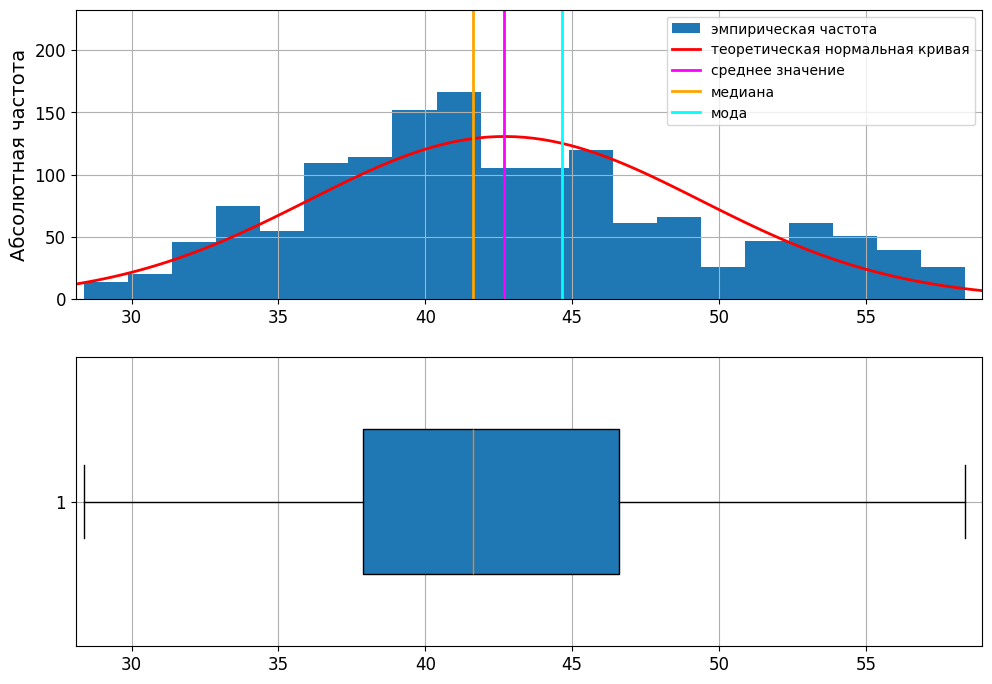

In [38]:
graph_hist_boxplot_mpl(np.array(data['Price']))